In [1]:
import pandas as pd
import numpy as np
import bitmexData
import matplotlib.pyplot as plt
from sklearn import preprocessing

# Steps

<ol>
  <li>Load Data from CSV and API</li>
  <li>Quick look at data</li>
  <li>Create variables for ratios</li>
  <li>Plot data</li>
  <li>Check correlations</li>
</ol>

# Load the Data from CSV

In [2]:
sentiment = pd.read_csv('augmento_assignment_data.csv').set_index('date')
sentiment.index = pd.to_datetime(sentiment.index)

# Get the Data from API

<b>bitmexData</b> extracts data from API.

In [3]:
# need max amount of points is about 12000. Need to run twice to get data
year1 = bitmexData.Hourly('2016-11-01','2018-03-07','XBTUSD')
df1 = year1.get_data_all()
year2 = bitmexData.Hourly('2018-03-07','2019-03-08','XBTUSD')
df2 = year2.get_data_all()

Data loading...
Data loading...
Data loading...
Data loading...
Data loading...
Data loading...
Data loading...
Data loading...
Data loading...
Data loading...
Data loading...
Data loading...
Data loading...
Data loading...
Data loading...
Data loading...
Data loaded.
Data loading...
Data loading...
Data loading...
Data loading...
Data loading...
Data loading...
Data loading...
Data loading...
Data loading...
Data loading...
Data loading...
Data loading...
Data loaded.


In [4]:
data1 = pd.DataFrame(df1)
data2 = pd.DataFrame(df2)
df = pd.concat([data1,data2],axis=0)

### First look into data
It's hard to see but there is an unusual flat are around after January 2019.
These are 0 values for sentiment.
<br>
Lets look first how it looks like after computing the ratios

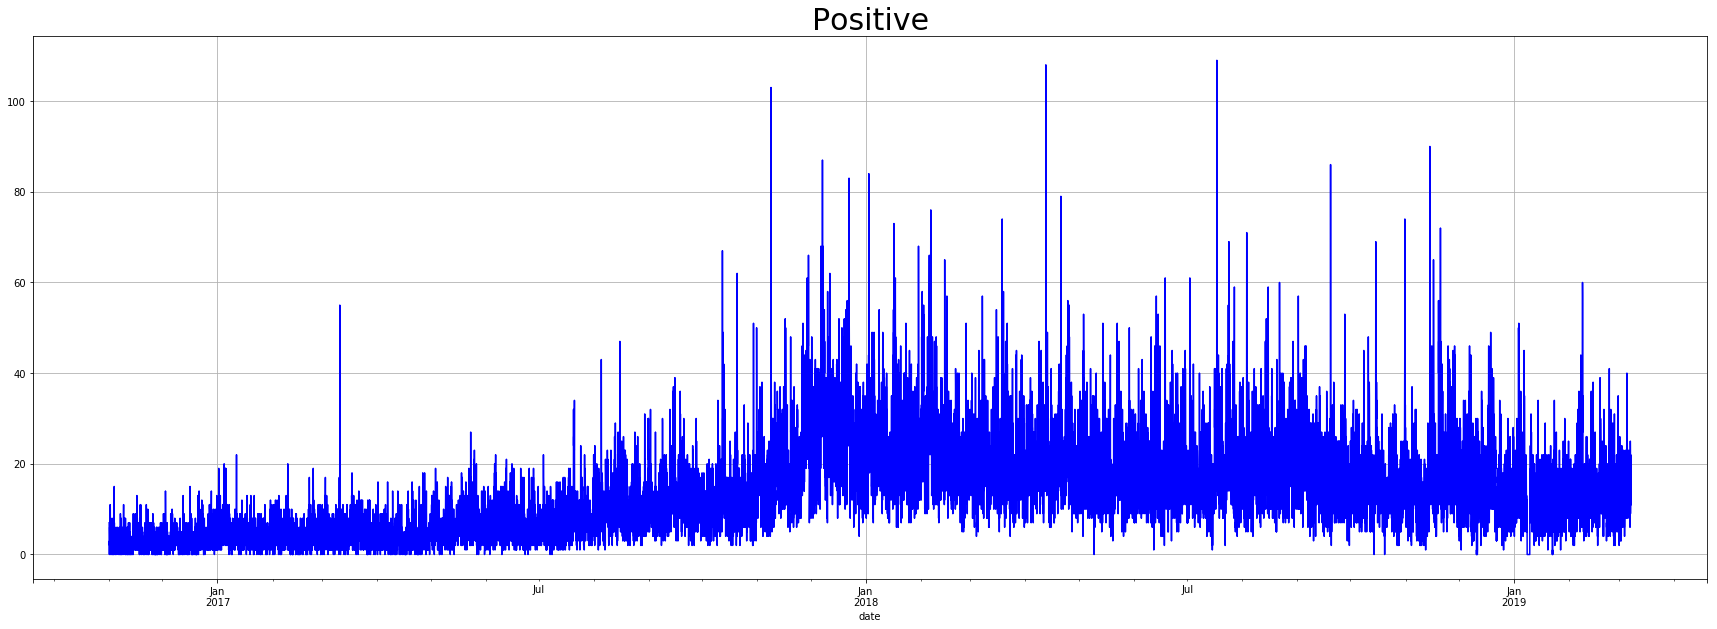

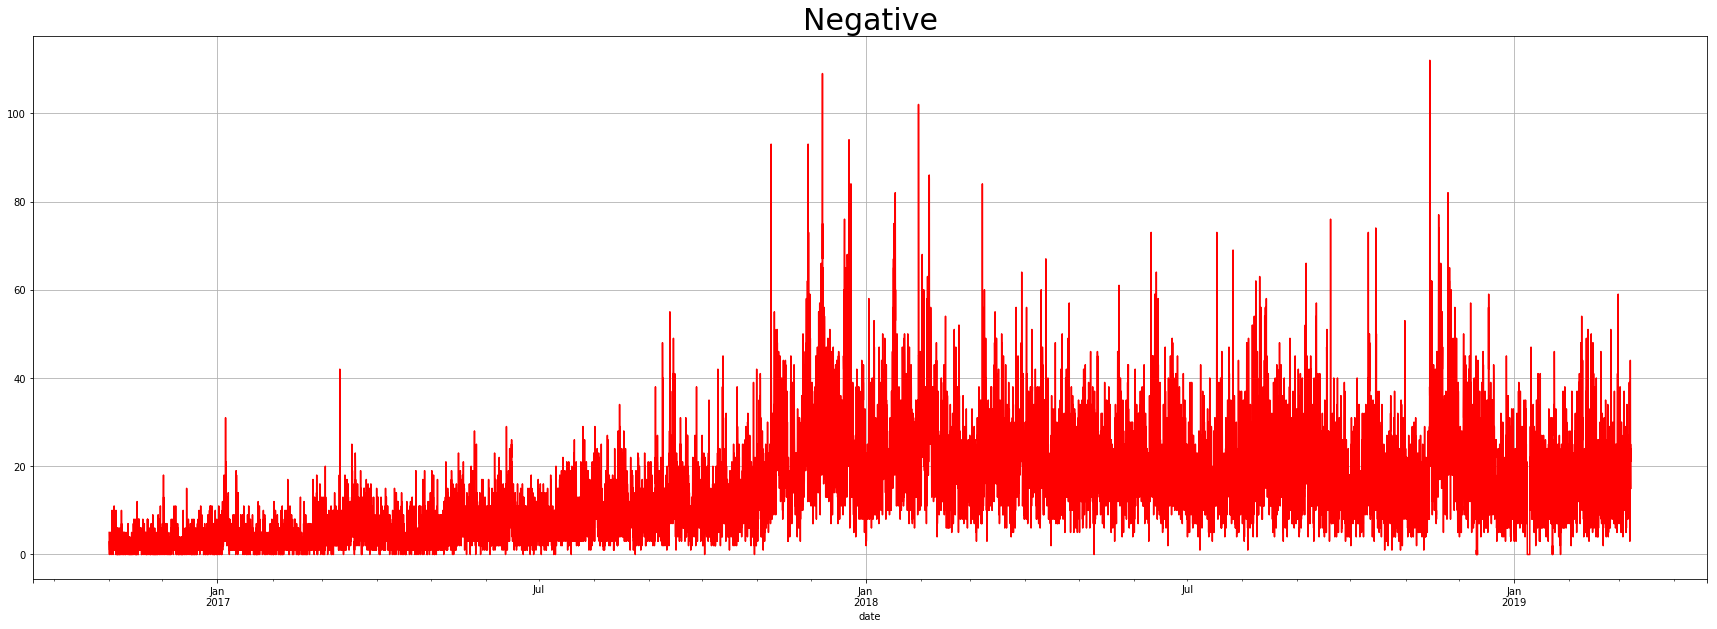

In [5]:
plt.figure(figsize=(30,10))
plt.title('Positive', fontsize=30)
ax1 = sentiment.Positive.plot(color='blue', grid=True)
plt.figure(figsize=(30,10))
plt.title('Negative', fontsize=30)
ax1 = sentiment.Negative.plot(color='red', grid=True)


plt.show()

In [6]:
# df[df.duplicated()]
# remove duplicates
data = df.drop_duplicates().set_index('timestamp')
data.index = pd.to_datetime(data.index)

# Find the ratio of positive to negative sentiment

$$ ratio = \frac{positive + 1}{negative + 1}$$

1 was added to numerator and denominator to account for $\frac{0}{0}$ and $\frac{x}{0}$
Problem, there is data starting from 2019-01-09 00:00:00, with 0 Negative and 0 Positive for a long period. calculating std using moving window will yield std = 0. mean/std = inf. Without smoothing, values will be nans and automatically ignored. when using window of 24, smoothing not recommended.
<br>


In [7]:
sentiment["ratio_pn"]=(sentiment["Positive"]+1)/(sentiment["Negative"]+1)

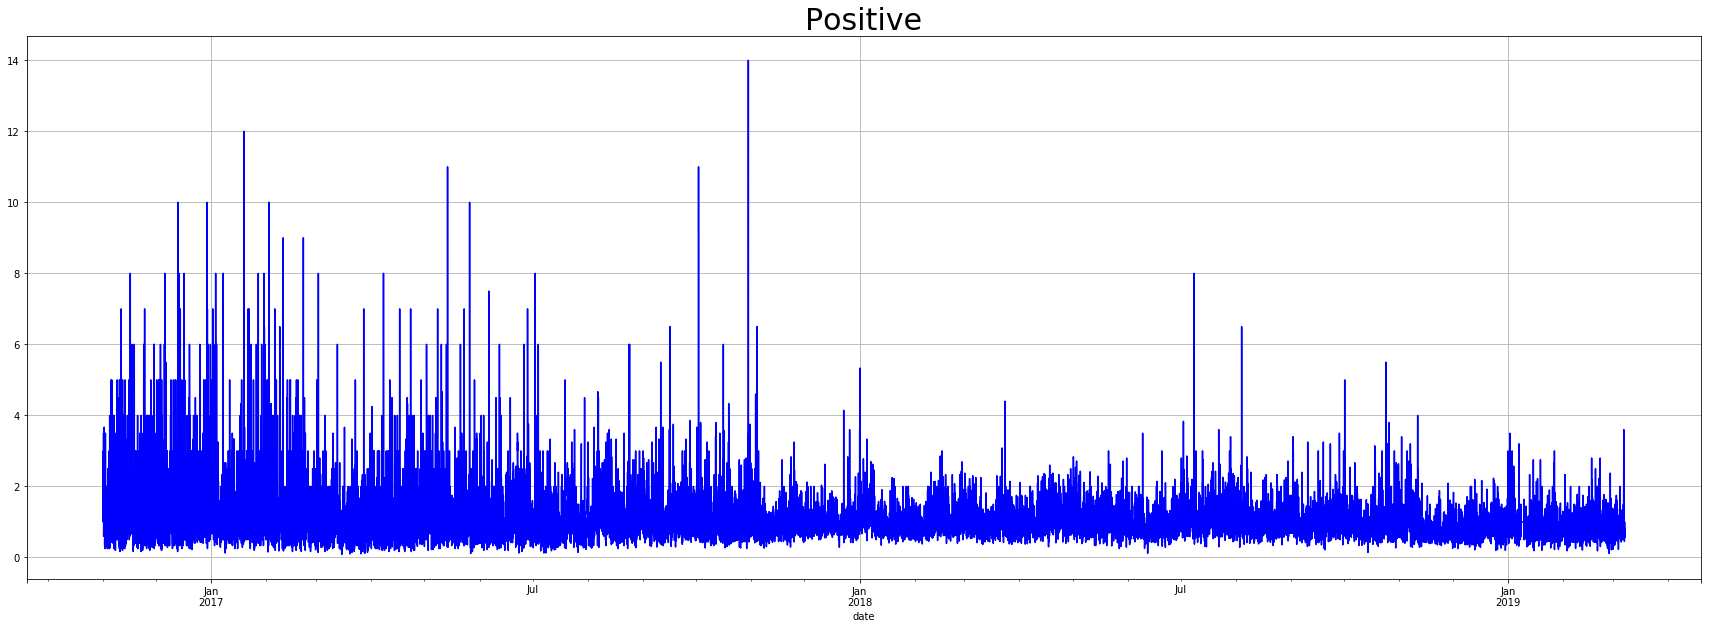

In [8]:
# There is a flat area around January 2019
# Lets look first how it looks like after computing the ratios
plt.figure(figsize=(30,10))
plt.title('Positive', fontsize=30)
ax1 = sentiment.ratio_pn.plot(color='blue', grid=True)

plt.show()

# Standardize time series

Rolling Window
<br>
<i>std and mean adjusted depending on the window</i>



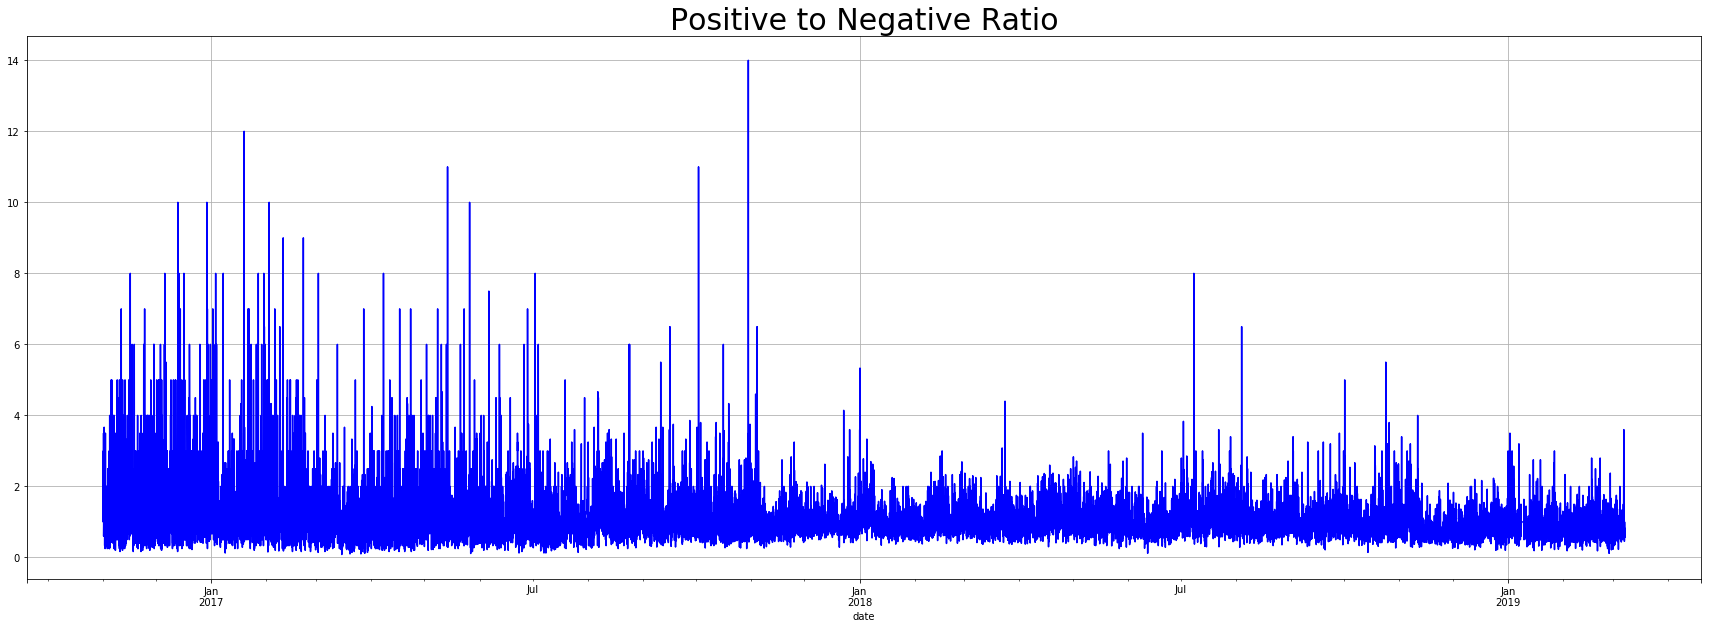

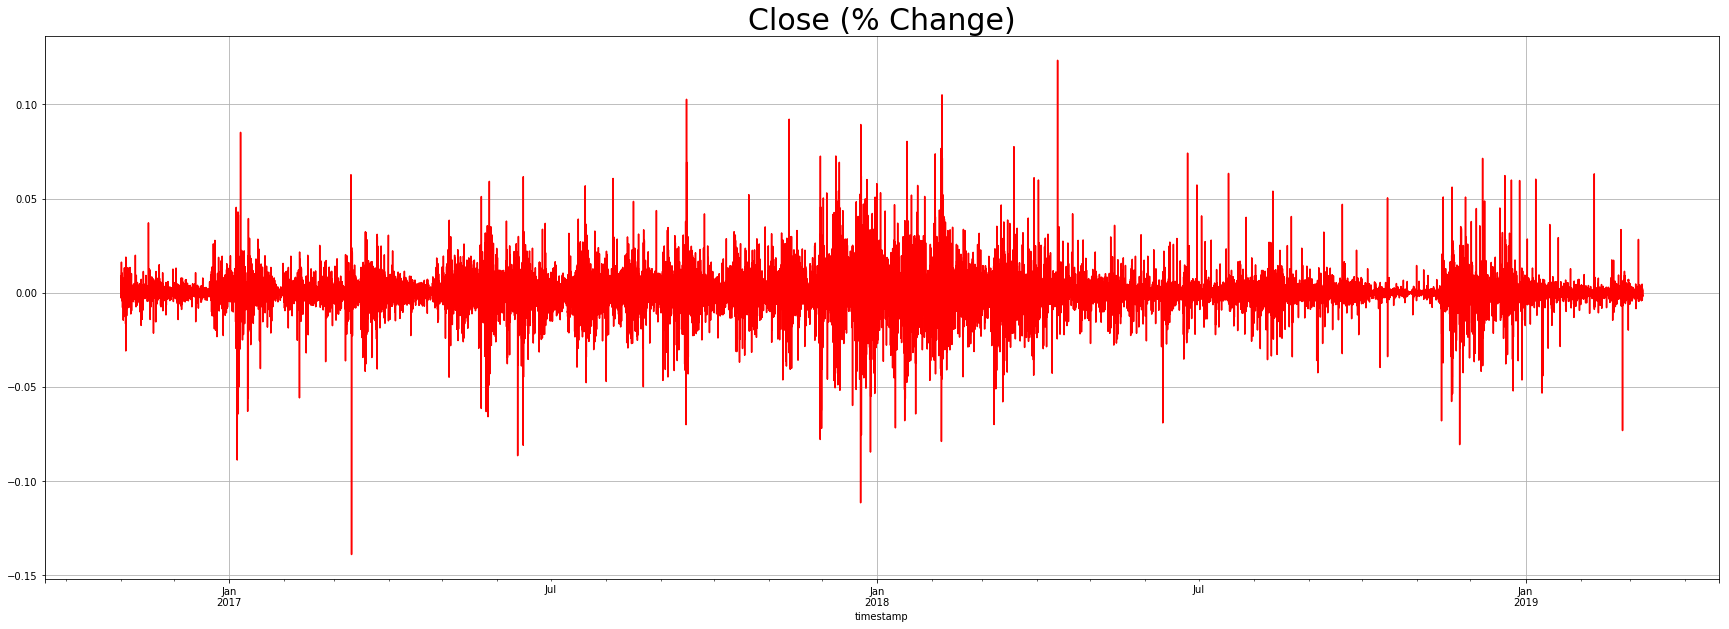

In [9]:
plt.figure(figsize=(30,10))
plt.title('Positive to Negative Ratio', fontsize=30)
ax1 = sentiment.ratio_pn.plot(color='blue', grid=True)
plt.figure(figsize=(30,10))
plt.title('Close (% Change)', fontsize=30)
ax1 = (data.close).pct_change().plot(color='red', grid=True)

#h1, l1 = ax1.get_legend_handles_labels()

#plt.legend(h1, l1, loc=2)
plt.show()

# Standardize Data

### Unusual Spike
Due to missing data, after standardizing, there is a spike in data. Division by 0 yield a value of inf. The final result will still give a pretty high correlation. Removing it will improve them significantly.

/Users/hoangluong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  
/Users/hoangluong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  This is separate from the ipykernel package so we can avoid doing imports until


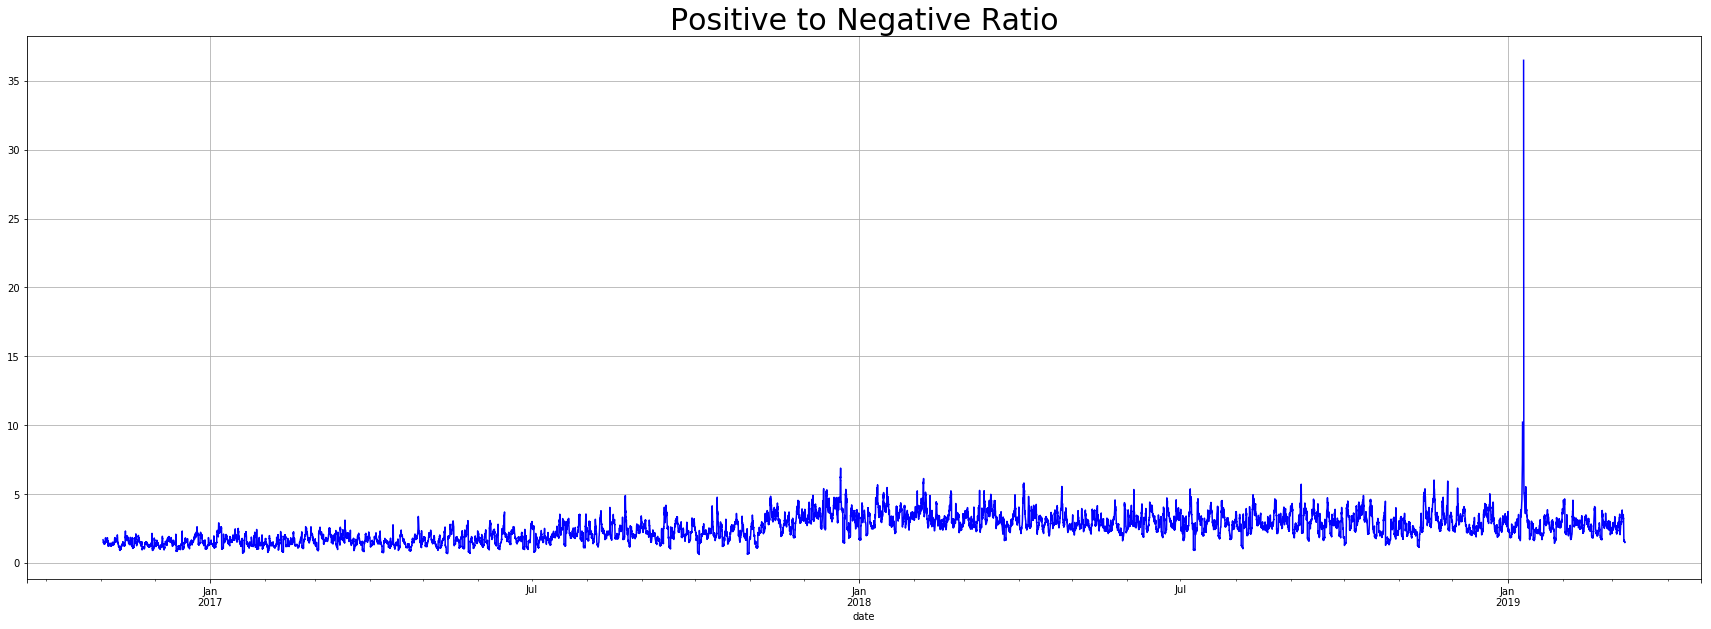

In [10]:
win=24
mean = pd.Series(sentiment["ratio_pn"]).rolling(window=win).apply(lambda x : np.mean(x))
std = pd.Series(sentiment["ratio_pn"]).rolling(window=win).apply(lambda x : np.std(x))
m2 =  mean/std
m2 = m2.rename("stat_ratio_pn")
plt.figure(figsize=(30,10))
plt.title('Positive to Negative Ratio', fontsize=30)
ax1 = m2.plot(color='blue', grid=True)

plt.show()

In [11]:
rc = pd.merge(pd.DataFrame((data.close)), pd.DataFrame(m2), left_index=True, right_index=True).dropna()


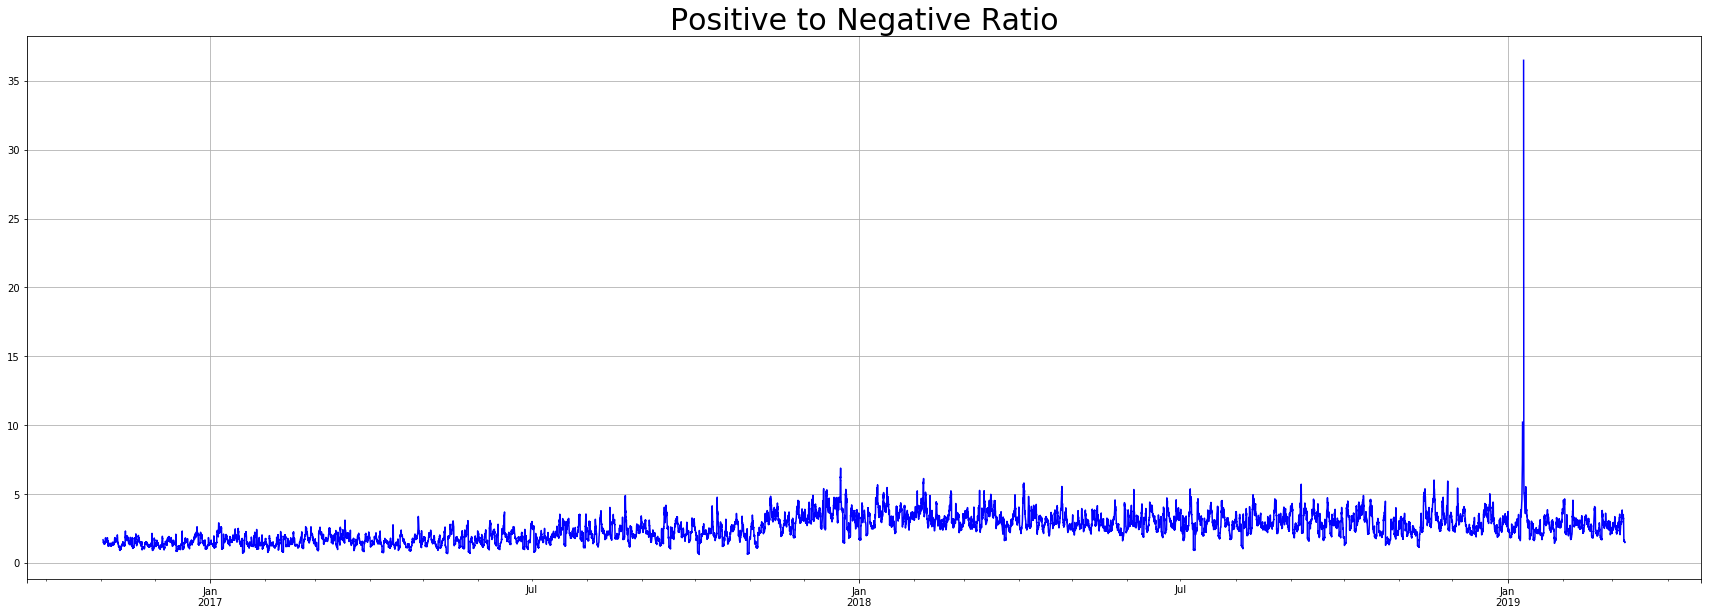

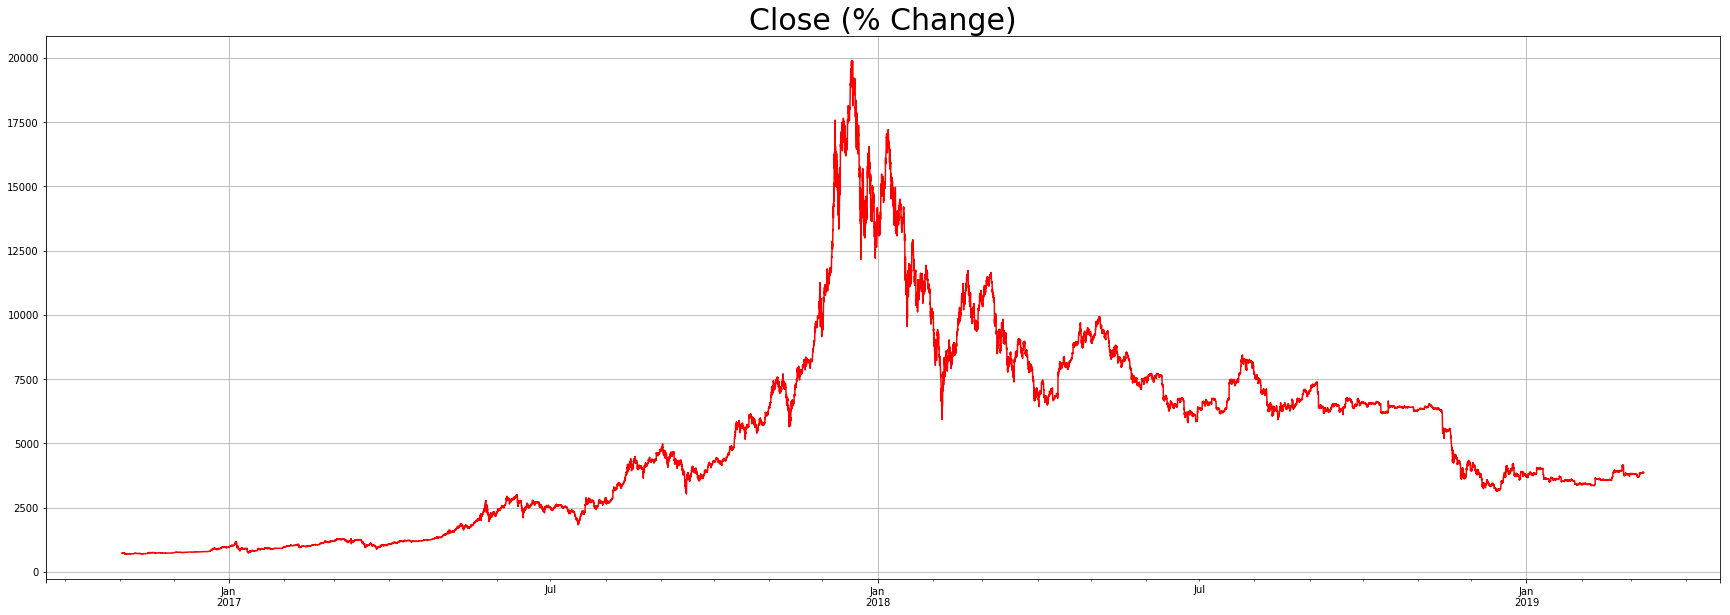

In [12]:
plt.figure(figsize=(30,10))
plt.title('Positive to Negative Ratio', fontsize=30)
ax1 = rc.stat_ratio_pn.plot(color='blue', grid=True)
plt.figure(figsize=(30,10))
plt.title('Close (% Change)', fontsize=30)
ax1 = (rc.close).plot(color='red', grid=True)

#h1, l1 = ax1.get_legend_handles_labels()

plt.show()

# Correlation

In [13]:
rc.corr()

,close,stat_ratio_pn
close,1.000000,0.583319
stat_ratio_pn,0.583319,1.000000


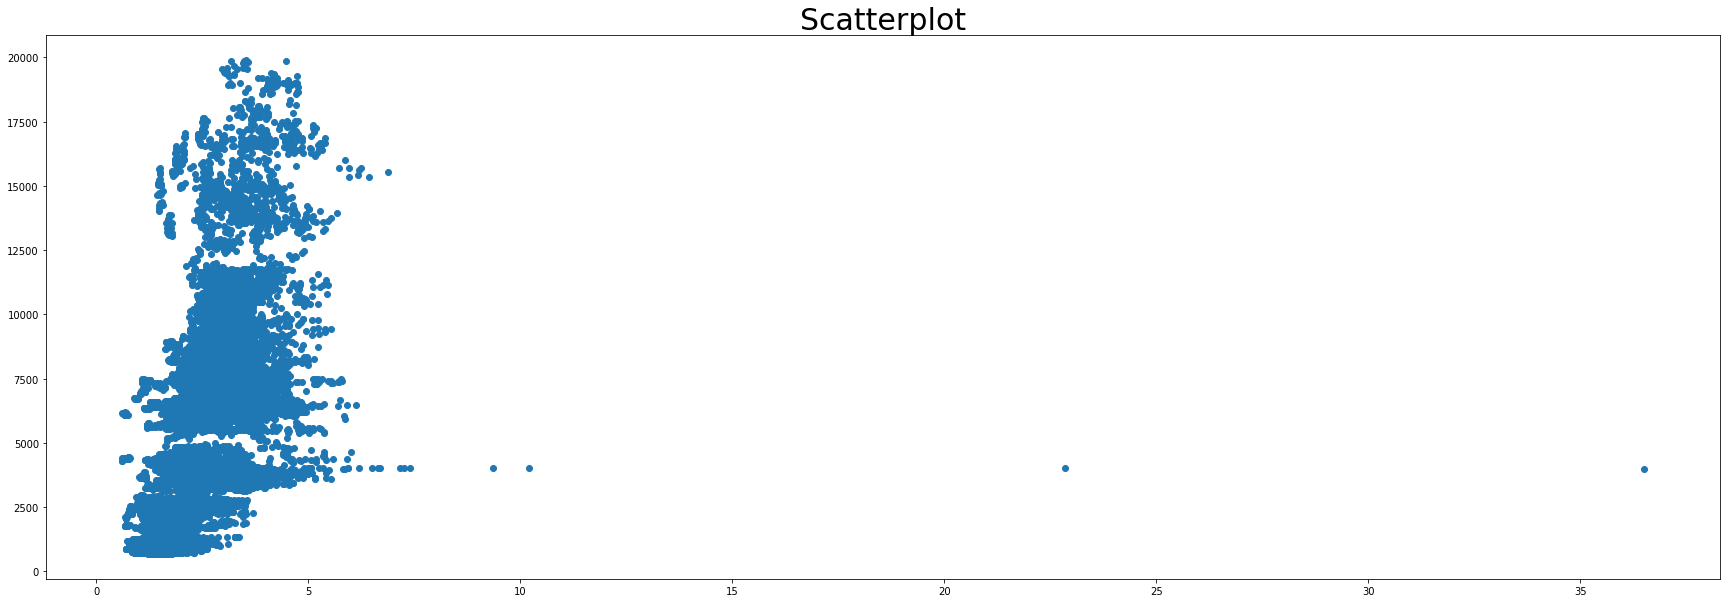

In [14]:
plt.figure(figsize=(30,10))
plt.title('Scatterplot', fontsize=30)
plt.scatter(rc.stat_ratio_pn,rc.close)
plt.show()

# Removing Outliars
Due to missing data, there are outliars. Let's see how it looks like after removing them.


In [15]:
#missing data (?)
sentiment['2019-01-08 12:00:00':'2019-01-09 23:00:00']=np.nan
sentiment = sentiment.dropna()

/Users/hoangluong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  
/Users/hoangluong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  This is separate from the ipykernel package so we can avoid doing imports until


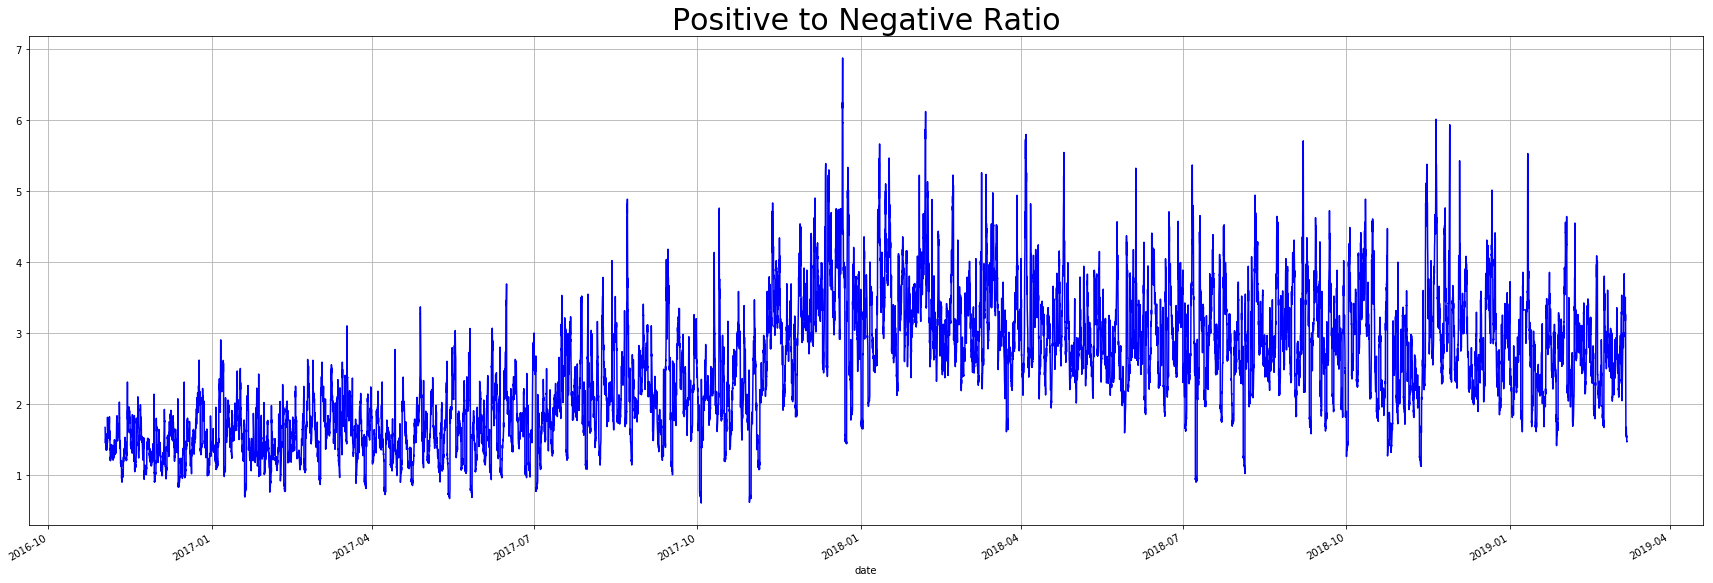

In [16]:
win=24
mean = pd.Series(sentiment["ratio_pn"]).rolling(window=win).apply(lambda x : np.mean(x))
std = pd.Series(sentiment["ratio_pn"]).rolling(window=win).apply(lambda x : np.std(x))
m2 =  mean/std
m2 = m2.rename("stat_ratio_pn")
plt.figure(figsize=(30,10))
plt.title('Positive to Negative Ratio', fontsize=30)
ax1 = m2.plot(color='blue', grid=True)

plt.show()

In [17]:
rc = pd.merge(pd.DataFrame((data.close)), pd.DataFrame(m2), left_index=True, right_index=True).dropna()


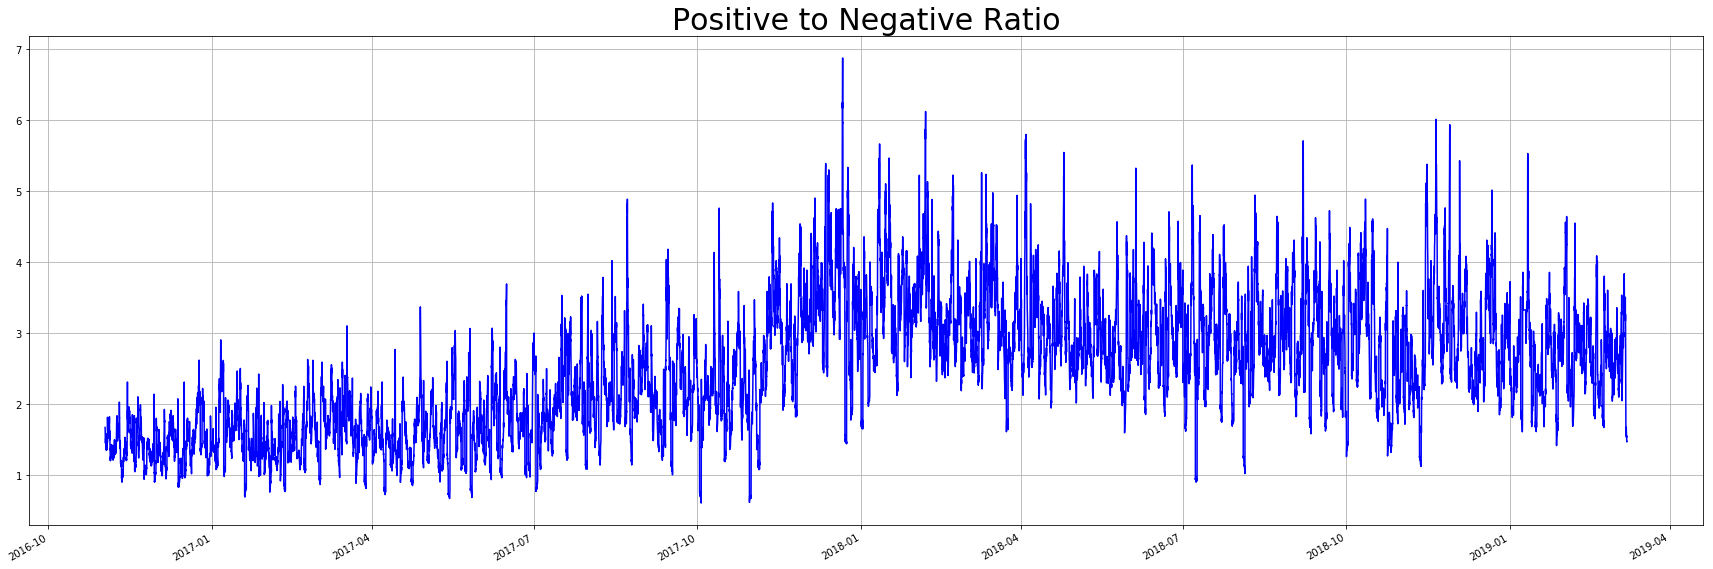

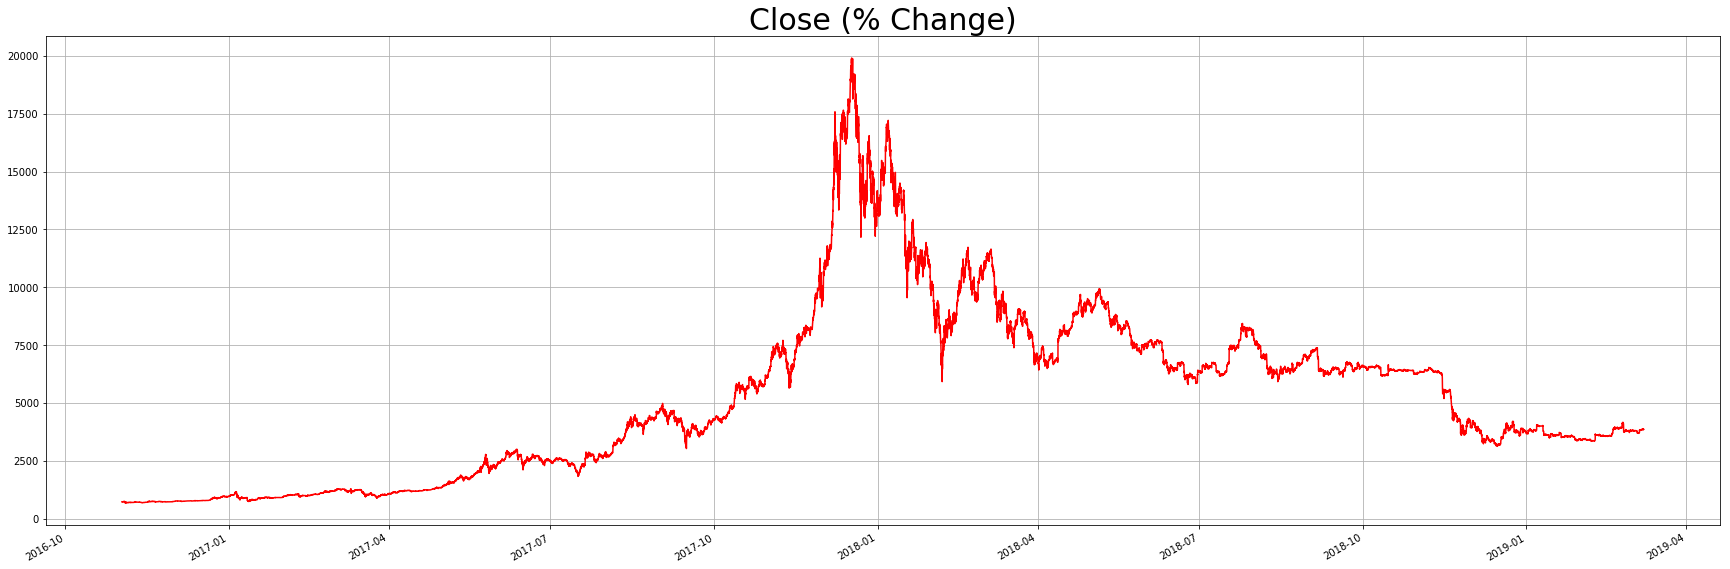

In [18]:
plt.figure(figsize=(30,10))
plt.title('Positive to Negative Ratio', fontsize=30)
ax1 = rc.stat_ratio_pn.plot(color='blue', grid=True)
plt.figure(figsize=(30,10))
plt.title('Close (% Change)', fontsize=30)
ax1 = (rc.close).plot(color='red', grid=True)

#h1, l1 = ax1.get_legend_handles_labels()

plt.show()

### Removing by outliars, obtained higher correlation
Correlation jumped to above 60% after removing missing values


In [19]:
rc.corr()

,close,stat_ratio_pn
close,1.000000,0.618412
stat_ratio_pn,0.618412,1.000000


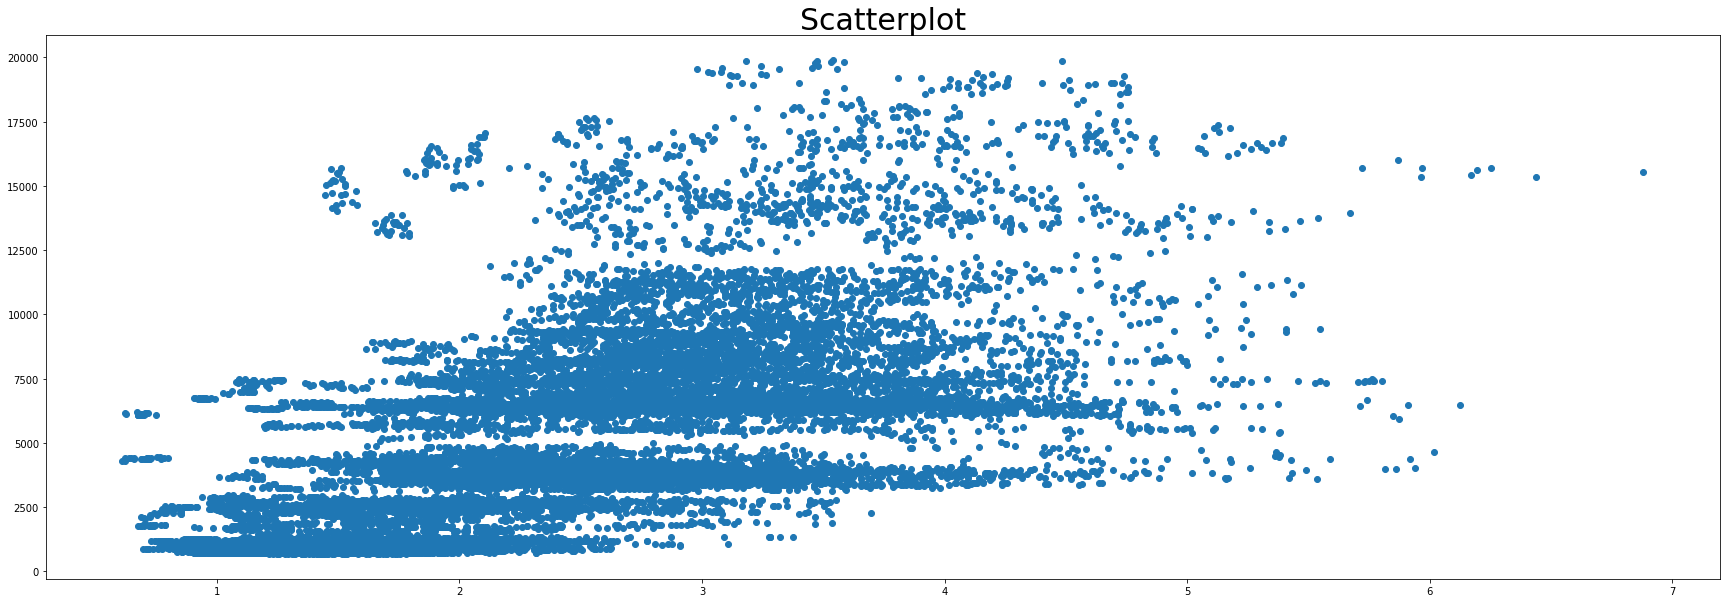

In [20]:
plt.figure(figsize=(30,10))
plt.title('Scatterplot', fontsize=30)
plt.scatter(rc.stat_ratio_pn,rc.close)
plt.show()

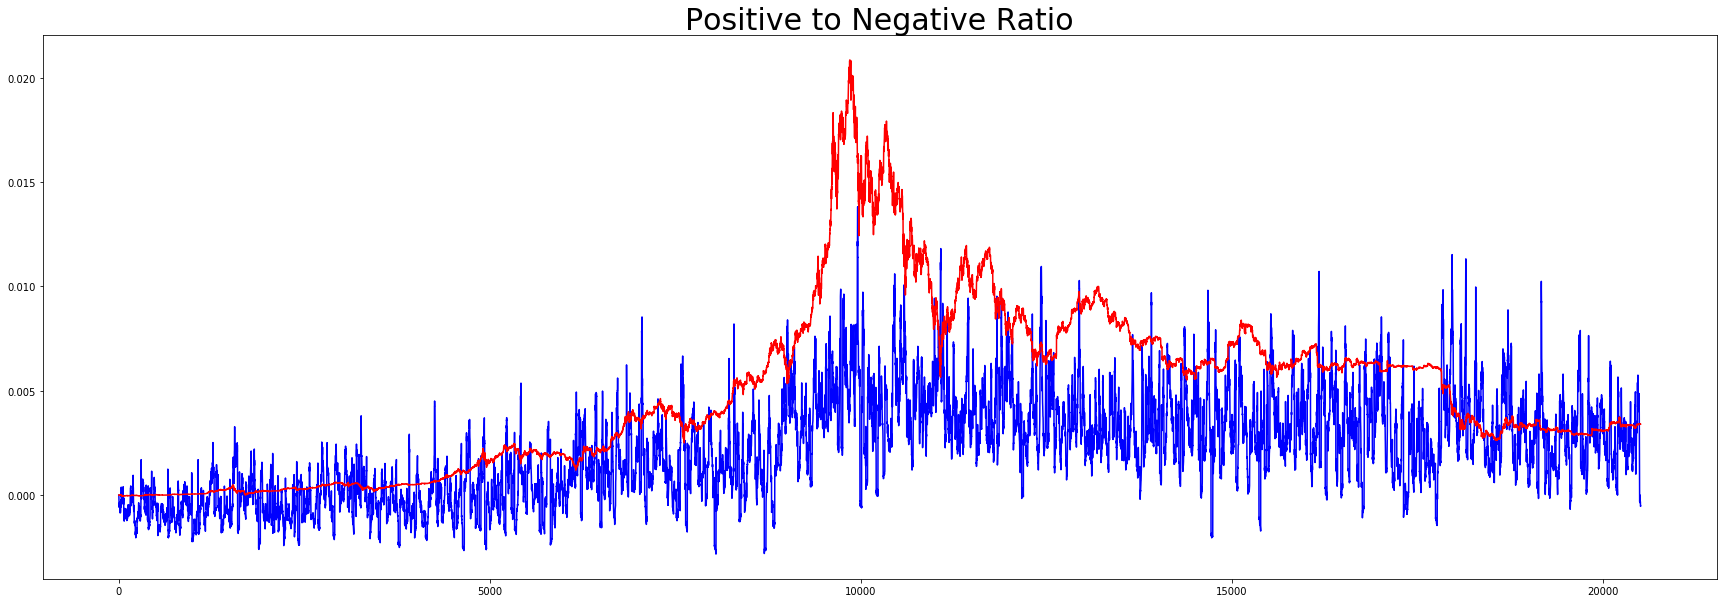

In [21]:
ratio = preprocessing.normalize([rc.stat_ratio_pn])[0]
close = preprocessing.normalize([rc.close])[0]
# start at the same point
ratio = ratio-ratio[0]
close = close-close[0]

plt.figure(figsize=(30,10))
plt.title('Positive to Negative Ratio', fontsize=30)
p1 = plt.plot(ratio, color='blue')
p2 = plt.plot(close, color='red')


plt.show()

# Another Ratio

$$ ratio = \frac{positive}{negative + positive}$$
or
$$ ratio = \frac{positive+1}{negative + positive + 2}$$


Again, I would add 1 to numerator and 2 to denominator (Laplacian Smoothing). It would help with values $\frac{0}{0}$ and $\frac{x}{0}$. Problem: there is data starting from 2019-01-09 00:00:00, with 0 Negative and 0 Positive for a long period. calculating std using moving window will yield std = 0. mean/std = inf. Without smoothing, values will be nans and automatically ignored. For window 48, smoothed ratio yields better results, sometimes 88% correlation.
<br>
I will continue with removed outliars and stay with 24 hours window

In [22]:
sentiment["ratio_pn"]=(sentiment["Positive"]+1)/(sentiment["Negative"]+sentiment["Positive"]+2)
win=24
#sentiment["ratio_pn"]=(sentiment["Positive"])/(sentiment["Negative"]+sentiment["Positive"])
##when using smoothed ratio, use window 48
#win=48

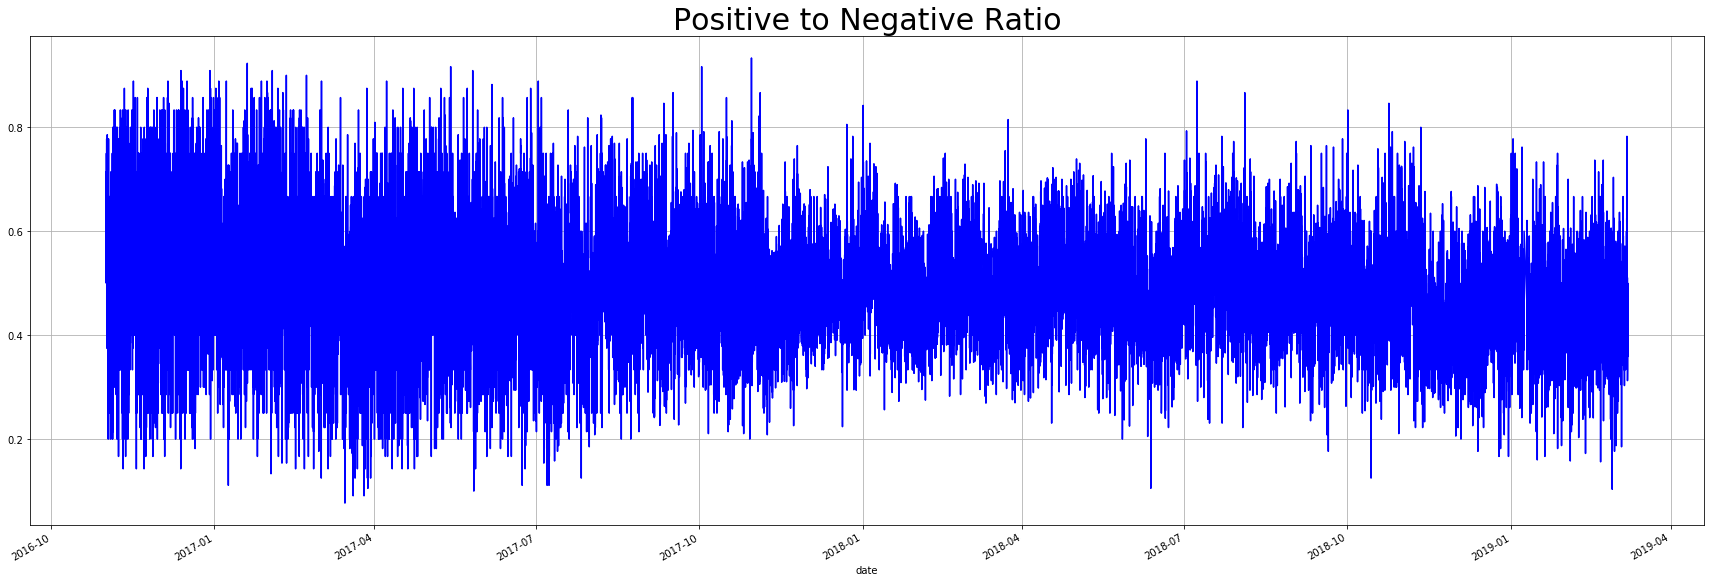

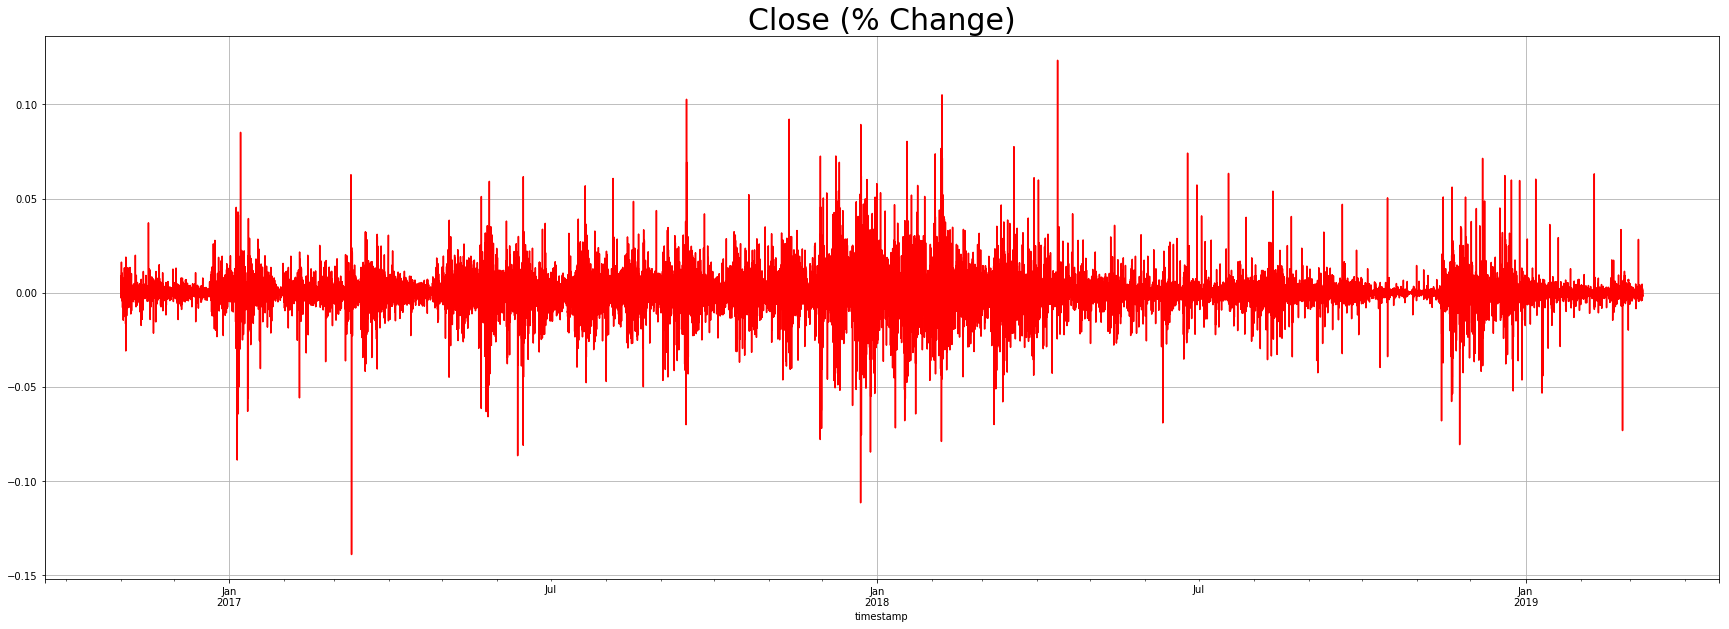

In [23]:
plt.figure(figsize=(30,10))
plt.title('Positive to Negative Ratio', fontsize=30)
ax1 = sentiment.ratio_pn.plot(color='blue', grid=True)
plt.figure(figsize=(30,10))
plt.title('Close (% Change)', fontsize=30)
ax1 = (data.close).pct_change().plot(color='red', grid=True)

#h1, l1 = ax1.get_legend_handles_labels()

#plt.legend(h1, l1, loc=2)
plt.show()

### Set the window for lags
#### highest at 384 hours lag

/Users/hoangluong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  """Entry point for launching an IPython kernel.
/Users/hoangluong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  


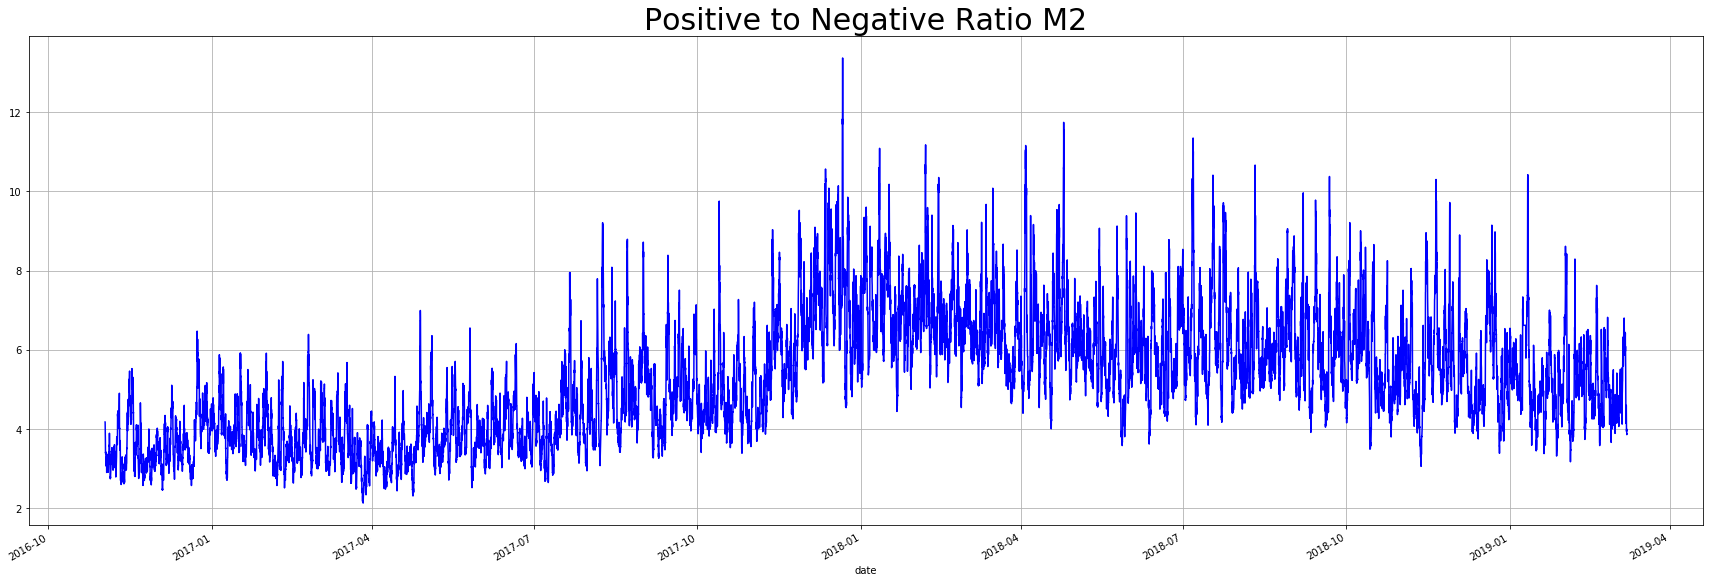

In [24]:
mean = pd.Series(sentiment["ratio_pn"]).rolling(window=win).apply(lambda x : np.mean(x))
std = pd.Series(sentiment["ratio_pn"]).rolling(window=win).apply(lambda x : np.std(x))
m2 =  mean/std
m2 = m2.rename("stat_ratio_pn")
plt.figure(figsize=(30,10))
plt.title('Positive to Negative Ratio M2', fontsize=30)
ax1 = m2.plot(color='blue', grid=True)

plt.show()

In [25]:
rc = pd.merge(pd.DataFrame((data.close)), pd.DataFrame(m2), left_index=True, right_index=True).dropna()


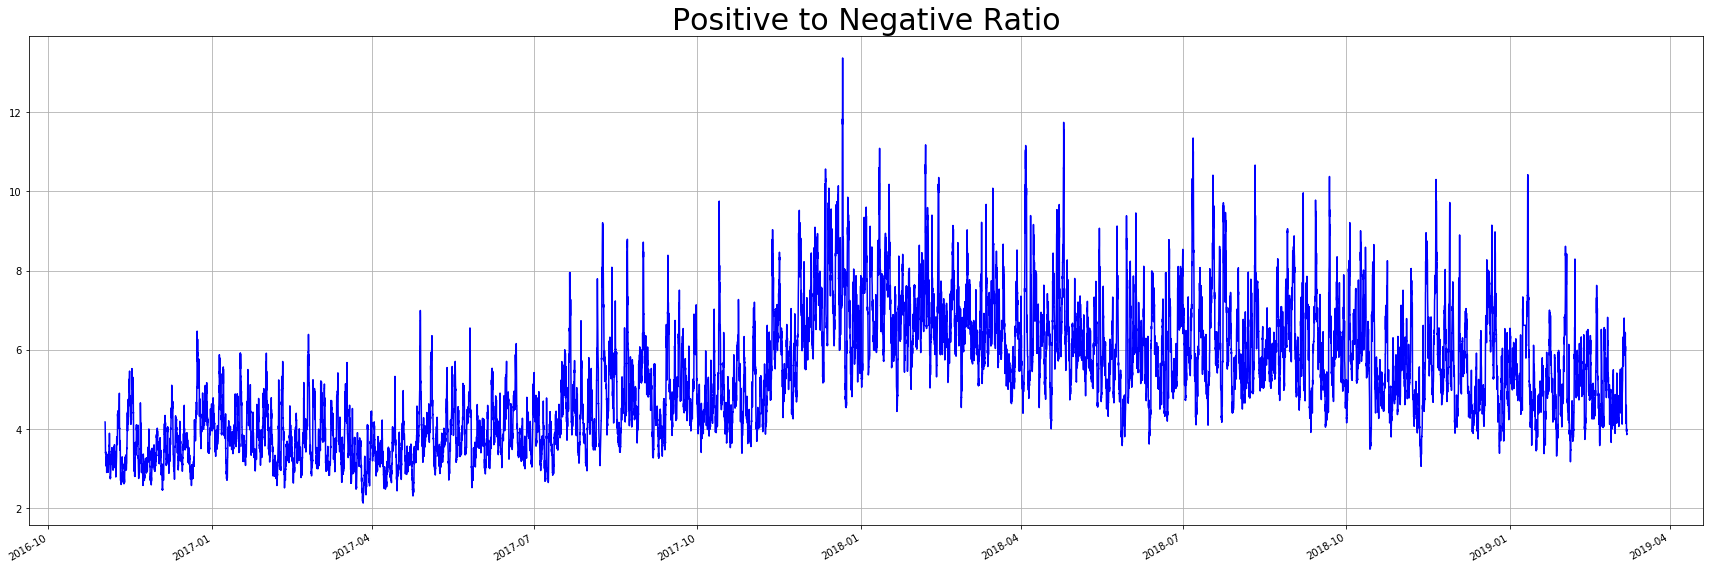

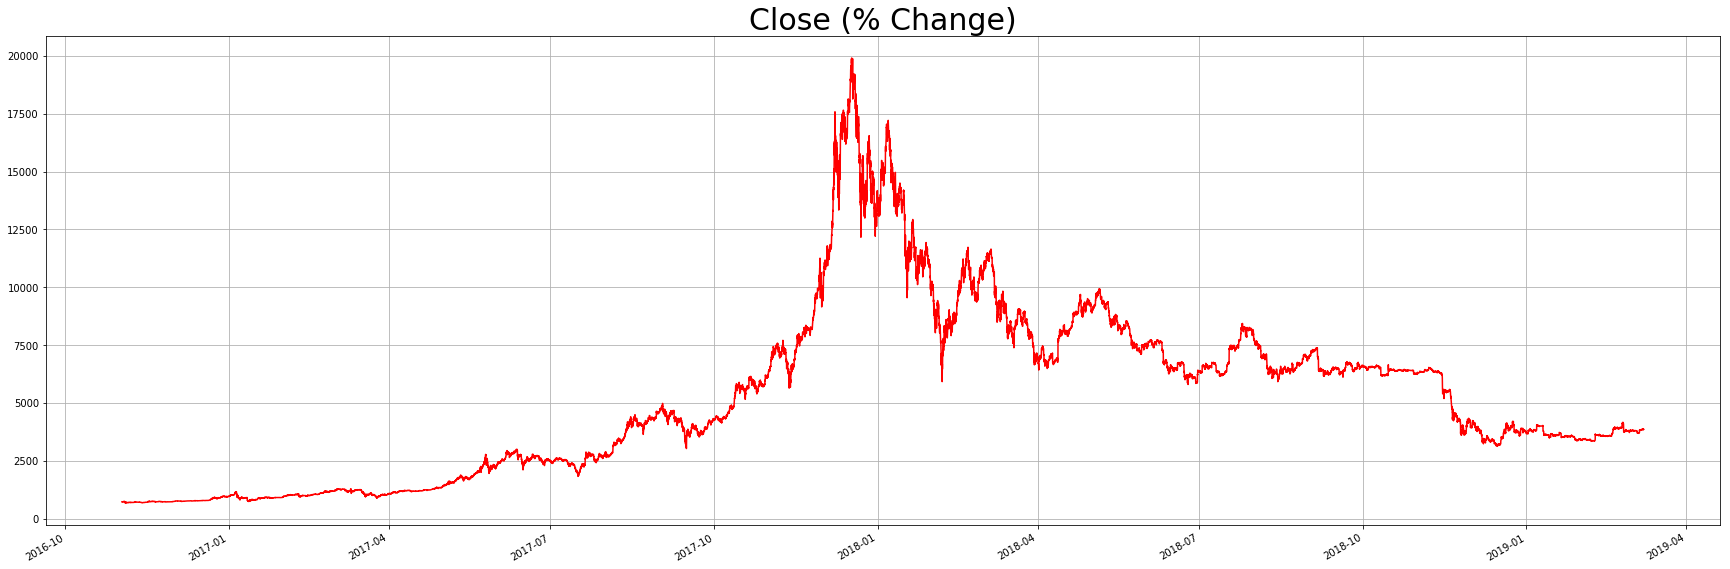

In [26]:
plt.figure(figsize=(30,10))
plt.title('Positive to Negative Ratio', fontsize=30)
ax1 = rc.stat_ratio_pn.plot(color='blue', grid=True)
plt.figure(figsize=(30,10))
plt.title('Close (% Change)', fontsize=30)
ax1 = (rc.close).plot(color='red', grid=True)

#h1, l1 = ax1.get_legend_handles_labels()

plt.show()

In [27]:
# We get much higher correlation
rc.corr()

,close,stat_ratio_pn
close,1.000000,0.698387
stat_ratio_pn,0.698387,1.000000


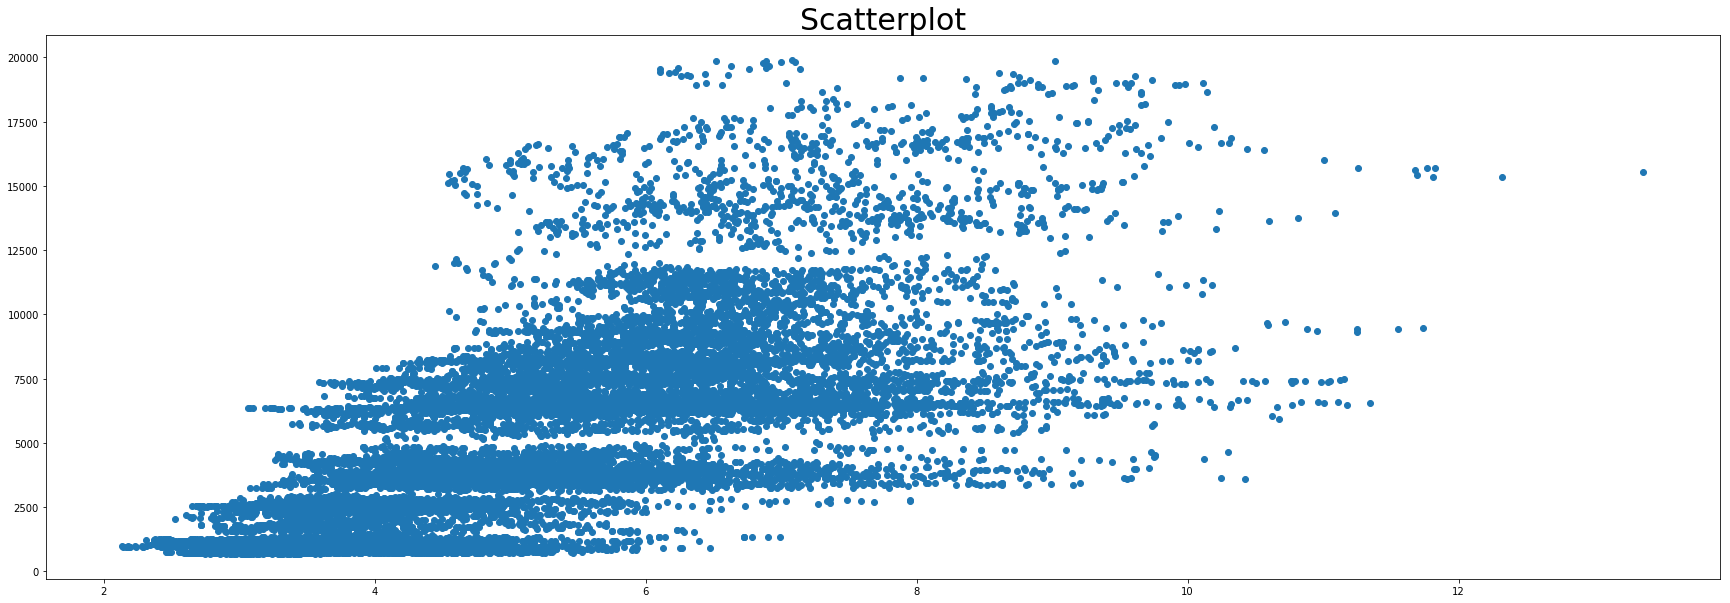

In [28]:
plt.figure(figsize=(30,10))
plt.title('Scatterplot', fontsize=30)
plt.scatter(rc.stat_ratio_pn,rc.close)
plt.show()

# Plot against each other
<b>Steps</b>:
1. normalize
2. plot

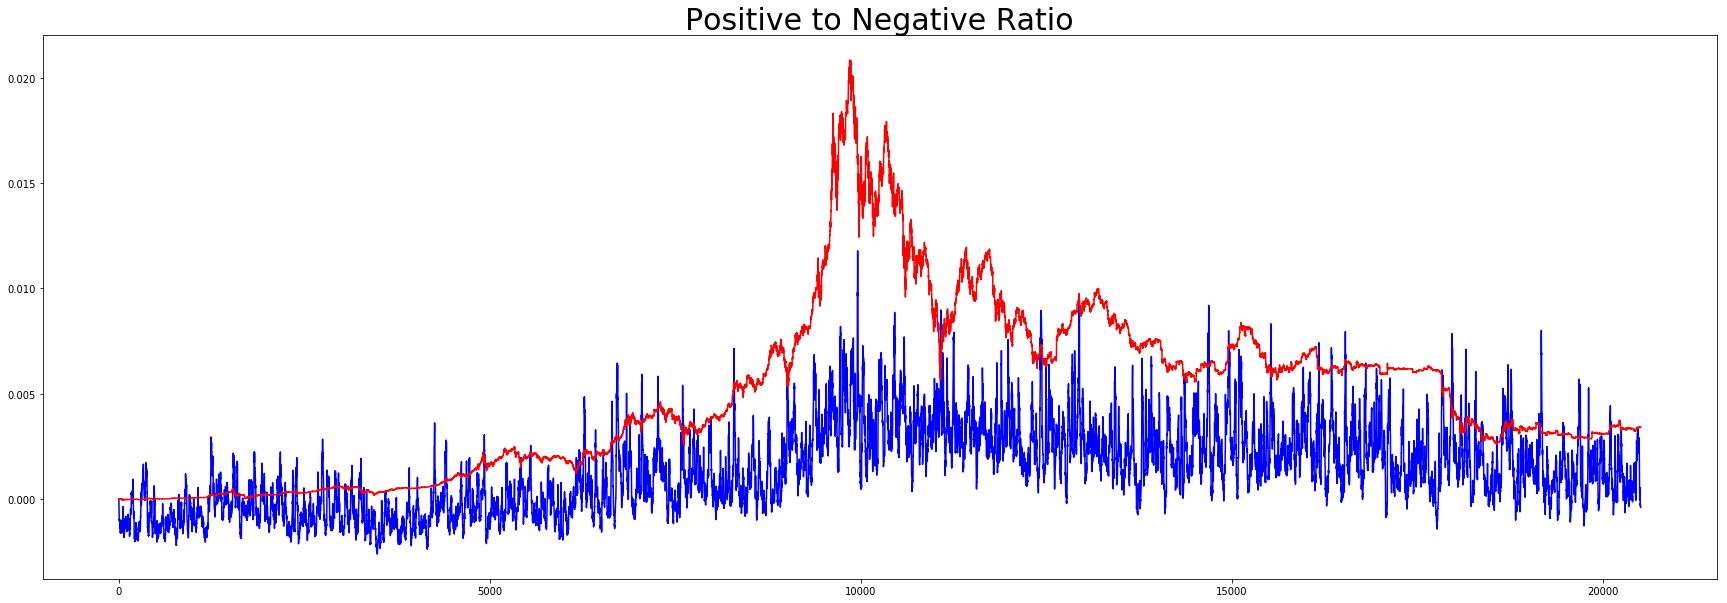

In [29]:
ratio = preprocessing.normalize([rc.stat_ratio_pn])[0]
close = preprocessing.normalize([rc.close])[0]
# start at the same point
ratio = ratio-ratio[0]
close = close-close[0]

plt.figure(figsize=(30,10))
plt.title('Positive to Negative Ratio', fontsize=30)
p1 = plt.plot(ratio, color='blue')
p2 = plt.plot(close, color='red')


plt.show()

### Observation

Increasing lags in moving window, increases correlation. Highest I got was over 0.88 (smoothed version), lag of 384 hours or 16 days.